# Token Classification

Attributing a label to each token in a sentence

It includes NER(Named entity recognition), Part of Speech(POS) tagging and chunking.

In this section we will fine tune a model(BERT) on NER.

Dataset Used : https://huggingface.co/datasets/conll2003

In [ ]:
!pip install datasets

In [6]:
from datasets import load_dataset

raw_datasets = load_dataset("conll2003")

In [7]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [8]:
print(raw_datasets['train'][0])

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


In [9]:
raw_datasets['train'].features['ner_tags'].feature.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

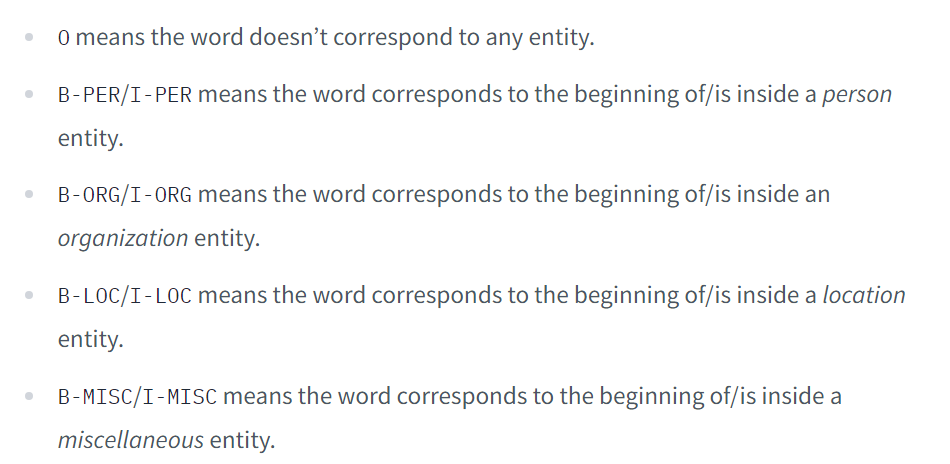

['O' ->  0 , 'B-PER' ->  1 , 'I-PER' ->  2 , 'B-ORG' ->  3 , 'I-ORG' ->  4 , 'B-LOC' ->  5 ,  'I-LOC' -> 6 , 'B-MISC' -> 7 , 'I-MISC'->  8 ]

For raw_datasets['train'][0], ner_tags and tokens are:

'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]

'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

So our 'EU' -> 3 -> 'B-ORG'

'German' -> 7 -> 'B-MISC'

'British' -> 7 -> 'B-MISC'


# Processing the data

In [10]:
raw_datasets = raw_datasets.remove_columns(['chunk_tags','id','pos_tags'])
raw_datasets = raw_datasets.rename_column('ner_tags','labels')
raw_datasets = raw_datasets.rename_column('tokens','words')

In [11]:
print(raw_datasets['train'][0]['words'])
print(raw_datasets['train'][0]['labels'])

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
[3, 0, 7, 0, 0, 0, 7, 0, 0]


In [12]:
label_names = raw_datasets['train'].features['labels'].feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

Applying Tokenizer

In [13]:
from transformers import AutoTokenizer
model_checkpoint = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Visulatization
input = tokenizer(raw_datasets['train'][0:2]['words'],is_split_into_words=True)
print(input)
print(input.tokens())
print(input.word_ids)
print(input.word_ids(0))
print(input.word_ids(1))
print(raw_datasets['train'][0:2]['words'])
for index,labels in enumerate(raw_datasets['train'][0:2]['labels']):
  print(index,labels)
  word_ids = input.word_ids(index)
  print(word_ids)

{'input_ids': [[101, 7270, 22961, 1528, 1840, 1106, 21423, 1418, 2495, 12913, 119, 102], [101, 1943, 14428, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1]]}
['[CLS]', 'EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'la', '##mb', '.', '[SEP]']
<bound method BatchEncoding.word_ids of {'input_ids': [[101, 7270, 22961, 1528, 1840, 1106, 21423, 1418, 2495, 12913, 119, 102], [101, 1943, 14428, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1]]}>
[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]
[None, 0, 1, None]
[['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], ['Peter', 'Blackburn']]
0 [3, 0, 7, 0, 0, 0, 7, 0, 0]
[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]
1 [1, 2]
[None, 0, 1, None]


Once tokenized we get more inputs than labels, so we need to do some alignment.

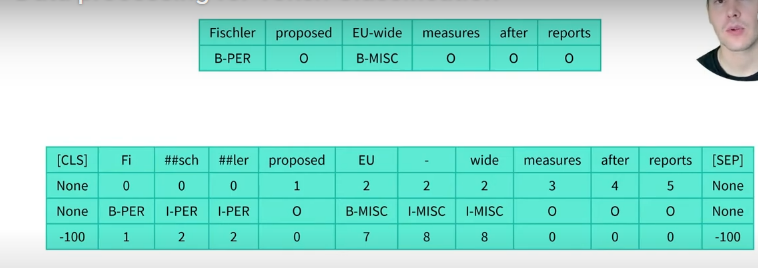

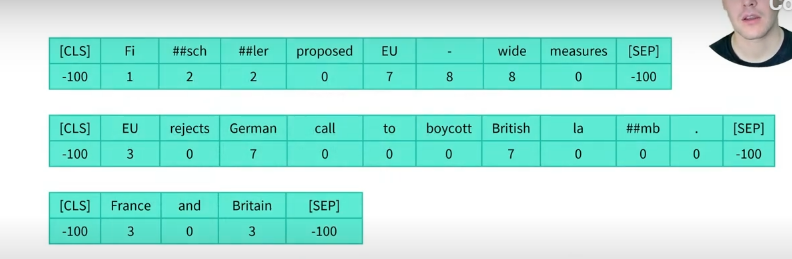

In [14]:
def shift_label(label):
  # If label if B-XXX we change it to I-XXX
  if label%2 == 1:
    label = label + 1;
  return label

def align_labels_with_tokens(labels,word_ids):
  new_labels = []
  current_word = None
  for word_id in word_ids:
    if word_id is None:
      new_labels.append(-100);
    elif word_id != current_word:
      current_word = word_id
      new_labels.append(labels[word_id])
    else:
      new_labels.append(shift_label(labels[word_id]))
  return new_labels

def tokenize_and_align_labels(examples):
  tokenized_inputs = tokenizer(examples['words'],truncation=True,is_split_into_words=True)
  new_labels = []
  for index,labels in enumerate(examples['labels']):
    word_ids = tokenized_inputs.word_ids(index)
    new_labels.append(align_labels_with_tokens(labels,word_ids))
  tokenized_inputs['labels'] = new_labels
  return tokenized_inputs

tokenized_datasets = raw_datasets.map(tokenize_and_align_labels, batched=True,)

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [15]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['words', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['words', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['words', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3453
    })
})

In [16]:
print(tokenized_datasets['train'][0]['words'])
print(tokenized_datasets['train'][0]['labels'])

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]


In [17]:
print(raw_datasets['train'][0]['labels'])
print(raw_datasets['train'][0]['words'])
print('\n')
print(tokenized_datasets['train'][0]['labels'])
print(tokenizer(" ".join(tokenized_datasets['train'][0]['words'])).tokens())

[3, 0, 7, 0, 0, 0, 7, 0, 0]
['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']


[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]
['[CLS]', 'EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'la', '##mb', '.', '[SEP]']


In [18]:
tokenized_datasets = tokenized_datasets.remove_columns(['words'])
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3453
    })
})

Collator for dynamic padding

In [ ]:
!pip install --upgrade transformers

In [20]:
from transformers import DataCollatorForTokenClassification

In [21]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [22]:
data_collator([tokenized_datasets['train'][i] for i in range(5)])['labels'] #does dynamic padding

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[-100,    3,    0,    7,    0,    0,    0,    7,    0,    0,    0, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100],
        [-100,    1,    2, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100],
        [-100,    5,    6,    6,    6,    0,    0,    0,    0,    0, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100],
        [-100,    0,    3,    4,    0,    0,    0,    0,    0,    0,    7,    0,
            0,    0,    0,    0,    0,    7,    0,    0,    0,    0,    0,    0,
            0,    0,    0

# Metric

The traditional framework used to evaluate token classification prediction is seqeval.

In [ ]:
!pip install seqeval

In [ ]:
!pip install evaluate

In [25]:
import evaluate

metric = evaluate.load("seqeval")

Let's see how metrics work

In [26]:
labels = raw_datasets['train'][0]['labels']
labels

[3, 0, 7, 0, 0, 0, 7, 0, 0]

In [27]:
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [28]:
labels1 = []
for i in labels:
  for j in range(len(label_names)):
    if j==i:
      labels1.append(label_names[j]);
      break;

labels1

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

In [29]:
labels = labels1
labels

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

In [30]:
new_labels = labels.copy()
new_labels[1] ='B-PER'
new_labels[0] = 'I-PER'
new_labels

['I-PER', 'B-PER', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

In [31]:
metric.compute(predictions=[new_labels], references=[labels])

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'MISC': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'ORG': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1},
 'PER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0},
 'overall_precision': 0.5,
 'overall_recall': 0.6666666666666666,
 'overall_f1': 0.5714285714285715,
 'overall_accuracy': 0.7777777777777778}

In [32]:
import numpy as np


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

# Defining the model

In [33]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [34]:
print(id2label)
print(label2id)

{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}


In [35]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
model.config.num_labels

9

# Fine tuning the model

In [37]:
from huggingface_hub import notebook_login

notebook_login()

In [38]:
!pip install transformers[torch]>=4.0.0 accelerate>=0.20.1

In [39]:
from transformers import TrainingArguments

args = TrainingArguments(
    "bert-finetuned-ner",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True,
)

For instance, when we pushed the model to the huggingface-course organization, we added hub_model_id="huggingface-course/bert-finetuned-ner" to TrainingArguments. By default, the repository used will be in your namespace and named after the output directory you set.

In [40]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.071800,0.066967,0.910969,0.935039,0.922847,0.981692
2,0.036100,0.060830,0.933179,0.947156,0.940115,0.985680
3,0.023000,0.060737,0.937728,0.952878,0.945242,0.986666


TrainOutput(global_step=5268, training_loss=0.06610161849016842, metrics={'train_runtime': 623.6501, 'train_samples_per_second': 67.543, 'train_steps_per_second': 8.447, 'total_flos': 920580703084350.0, 'train_loss': 0.06610161849016842, 'epoch': 3.0})

In [41]:
trainer.push_to_hub(commit_message="Training complete")

'https://huggingface.co/neural-net-rahul/bert-finetuned-ner/tree/main/'

# Using the fine tuned model

In [45]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "/content/bert-finetuned-ner"
token_classifier = pipeline(
    "token-classification", model=model_checkpoint, aggregation_strategy="simple"
)

# Validation

In [46]:
token_classifier("My name is Rahul and I work at Facebook as a Chief Scientist.")

[{'entity_group': 'PER',
  'score': 0.99788773,
  'word': 'Rahul',
  'start': 11,
  'end': 16},
 {'entity_group': 'ORG',
  'score': 0.9964232,
  'word': 'Facebook',
  'start': 31,
  'end': 39}]

In [47]:
token_classifier("A member of the wealthy South African Musk family, Elon was born in Pretoria and briefly attended the University of Pretoria before immigrating to Canada at age 18, acquiring citizenship through his Canadian-born mother.")

[{'entity_group': 'MISC',
  'score': 0.99792063,
  'word': 'South African',
  'start': 24,
  'end': 37},
 {'entity_group': 'PER',
  'score': 0.9905541,
  'word': 'Musk',
  'start': 38,
  'end': 42},
 {'entity_group': 'PER',
  'score': 0.9982298,
  'word': 'Elon',
  'start': 51,
  'end': 55},
 {'entity_group': 'LOC',
  'score': 0.99903715,
  'word': 'Pretoria',
  'start': 68,
  'end': 76},
 {'entity_group': 'ORG',
  'score': 0.9939782,
  'word': 'University of Pretoria',
  'start': 102,
  'end': 124},
 {'entity_group': 'LOC',
  'score': 0.99955374,
  'word': 'Canada',
  'start': 147,
  'end': 153},
 {'entity_group': 'MISC',
  'score': 0.9668379,
  'word': 'Canadian - born',
  'start': 199,
  'end': 212}]